**This notebook covers creating neural model for predicting accuracy of coffee roasting based on temprature and duration using tensorflow**

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [18]:
# let's prepare our dataset
def load_coffee_data():
    """ Creates a coffee roasting data set.
        roasting duration: 12-15 minutes is best
        temperature range: 175-260C is best
    """
    rng = np.random.default_rng(2)
    X = rng.random(400).reshape(-1,2)
    X[:,1] = X[:,1] * 4 + 11.5          # 12-15 min is best
    X[:,0] = X[:,0] * (285-150) + 150  # 350-500 F (175-260 C) is best
    Y = np.zeros(len(X))
    
    i=0
    for t,d in X:
        y = -3/(260-175)*t + 21
        if (t > 175 and t < 260 and d > 12 and d < 15 and d<=y ):
            Y[i] = 1
        else:
            Y[i] = 0
        i += 1

    return (X, Y.reshape(-1,1))

In [19]:
X,Y = load_coffee_data();
print(X.shape, Y.shape)

(200, 2) (200, 1)


In [20]:
dlc = dict(dlblue = '#0096ff', dlorange = '#FF9300', dldarkred='#C00000', dlmagenta='#FF40FF', dlpurple='#7030A0', dldarkblue =  '#0D5BDC')
dlblue = '#0096ff'; dlorange = '#FF9300'; dldarkred='#C00000'; dlmagenta='#FF40FF'; dlpurple='#7030A0'; dldarkblue =  '#0D5BDC'
dlcolors = [dlblue, dlorange, dldarkred, dlmagenta, dlpurple]

In [21]:
def plt_roast(X,Y):
    Y = Y.reshape(-1,)
    colormap = np.array(['r', 'b'])
    fig, ax = plt.subplots(1,1,)
    ax.scatter(X[Y==1,0],X[Y==1,1], s=70, marker='x', c='red', label="Good Roast" )
    ax.scatter(X[Y==0,0],X[Y==0,1], s=100, marker='o', facecolors='none', 
               edgecolors=dlc["dldarkblue"],linewidth=1,  label="Bad Roast")
    tr = np.linspace(175,260,50)
    ax.plot(tr, (-3/85) * tr + 21, color=dlc["dlpurple"],linewidth=1)
    ax.axhline(y=12,color=dlc["dlpurple"],linewidth=1)
    ax.axvline(x=175,color=dlc["dlpurple"],linewidth=1)
    ax.set_title(f"Coffee Roasting", size=16)
    ax.set_xlabel("Temperature \n(Celsius)",size=12)
    ax.set_ylabel("Duration \n(minutes)",size=12)
    ax.legend(loc='upper right')
    plt.show()

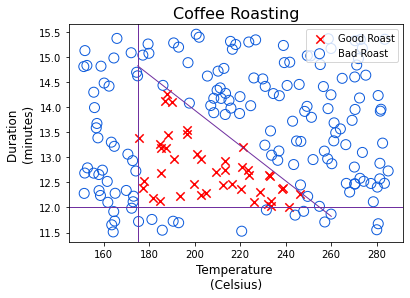

In [22]:
plt_roast(X,Y)

In [23]:
print(f"Temperature Max, Min pre normalization: {np.max(X[:,0]):0.2f}, {np.min(X[:,0]):0.2f}")
print(f"Duration    Max, Min pre normalization: {np.max(X[:,1]):0.2f}, {np.min(X[:,1]):0.2f}")

Temperature Max, Min pre normalization: 284.99, 151.32
Duration    Max, Min pre normalization: 15.45, 11.51


In [24]:
norm_l = tf.keras.layers.Normalization(axis = -1)
norm_l.adapt(X) # learns mean and variance
X_norm = norm_l(X)

print(f"Temperature Max, Min post normalization: {np.max(X_norm[:,0]):0.2f}, {np.min(X_norm[:,0]):0.2f}")
print(f"Duration    Max, Min post normalization: {np.max(X_norm[:,1]):0.2f}, {np.min(X_norm[:,1]):0.2f}")

Temperature Max, Min post normalization: 1.66, -1.69
Duration    Max, Min post normalization: 1.79, -1.70


In [31]:
# Now let's create a larger dataset by replicating the size of training data

Xt = np.tile(X_norm,(1000,1))
Yt = np.tile(Y,(1000,1))
print(Xt.shape, Yt.shape)  

(200000, 2) (200000, 1)


In [26]:
tf.random.set_seed(1234)  # applied to achieve consistent results

# let's create a tensorflow model

model = Sequential([
    tf.keras.Input(shape=(2,)),
    Dense(3, activation='sigmoid', name='layer1'),
    Dense(1, activation='sigmoid', name='layer2')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 3)                 9         
                                                                 
 layer2 (Dense)              (None, 1)                 4         
                                                                 
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


In [28]:
# now let's understand the weights initiated or assigned here

W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print(f"W1{W1.shape}:\n", W1, f"\nb1{b1.shape}:", b1)
print(f"W2{W2.shape}:\n", W2, f"\nb2{b2.shape}:", b2)

W1(2, 3):
 [[ 0.56057835  0.38515842  0.50373244]
 [-0.00837302  0.84107745 -0.7578863 ]] 
b1(3,): [0. 0. 0.]
W2(3, 1):
 [[ 0.11484873]
 [-0.6009397 ]
 [-0.10551345]] 
b2(1,): [0.]


In [32]:
# now let's compile the model and fit the training data in the model

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
)

model.fit(Xt,Yt,epochs=10)

Epoch 1/10
6250/6250 [==============================] - 9s 1ms/step - loss: 0.1841
Epoch 2/10
6250/6250 [==============================] - 8s 1ms/step - loss: 0.1183
Epoch 3/10
6250/6250 [==============================] - 8s 1ms/step - loss: 0.0785
Epoch 4/10
6250/6250 [==============================] - 8s 1ms/step - loss: 0.0193
Epoch 5/10
6250/6250 [==============================] - 8s 1ms/step - loss: 0.0118
Epoch 6/10
6250/6250 [==============================] - 8s 1ms/step - loss: 0.0082
Epoch 7/10
6250/6250 [==============================] - 8s 1ms/step - loss: 0.0058
Epoch 8/10
6250/6250 [==============================] - 8s 1ms/step - loss: 0.0041
Epoch 9/10
6250/6250 [==============================] - 8s 1ms/step - loss: 0.0030
Epoch 10/10
6250/6250 [==============================] - 8s 1ms/step - loss: 0.0022


In [34]:
# After fitting model weights have been updated, let's visualize them

W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print("W1:\n", W1, "\nb1:", b1)
print("W2:\n", W2, "\nb2:", b2)

W1:
 [[ -0.10557949  14.429086   -10.907287  ]
 [ -8.960666    11.960417    -0.24943109]] 
b1: [-11.2294235   1.7860184 -11.88224  ]
W2:
 [[-44.39578 ]
 [-41.494465]
 [-48.592823]] 
b2: [25.405516]


In [36]:
# Let's use fixed weights that were used earlier for training the model to accuracy

W1 = np.array([
    [-8.94,  0.29, 12.89],
    [-0.17, -7.34, 10.79]] )
b1 = np.array([-9.87, -9.28,  1.01])
W2 = np.array([
    [-31.38],
    [-27.86],
    [-32.79]])
b2 = np.array([15.54])
model.get_layer("layer1").set_weights([W1,b1])
model.get_layer("layer2").set_weights([W2,b2])

In [39]:
# Now let's compute the prediction from the model based on a particular example

X_test = np.array([
    [200,13.9],  # postive example
    [200,17]])   # negative example
X_testn = norm_l(X_test)
predictions = model.predict(X_testn)
print("predictions = \n", predictions)

1/1 [==============================] - 0s 22ms/step
predictions = 
 [[9.625139e-01]
 [3.031606e-08]]


In [41]:
# now let's compute the decision based on a threshold

yhat = np.zeros_like(predictions)
for i in range(len(predictions)):
    if predictions[i] >= 0.5:
        yhat[i] = 1
    else:
        yhat[i] = 0
print(f"decisions = \n{yhat}")

decisions = 
[[1.]
 [0.]]


In [43]:
# Another way to compute the decision
yhat = (predictions >= 0.5).astype(int)
print(f"decisions = \n{yhat}")

decisions = 
[[1]
 [0]]
